In [1]:
# library to convert .mat to np.array()
%pip install mat73

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Channel download
import mat73

data = mat73.loadmat('ChannelQriga_Freq_3kmh_Scena0_test_MIR_GIT_RAW_NR_3GPP_3D_UMa_NLOS_3p5GHz.mat')
# data

In [3]:
import numpy as np

H_initial = data['Hfrq'][0]['Chan']
H_dl = H_initial.transpose(1, 0, 2, 3)[:12, :, 0:600:12, :15] / np.abs(H_initial.max())
H_dl.shape



(12, 4, 50, 15)

/Users/pavelkr/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pavelkr/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


15

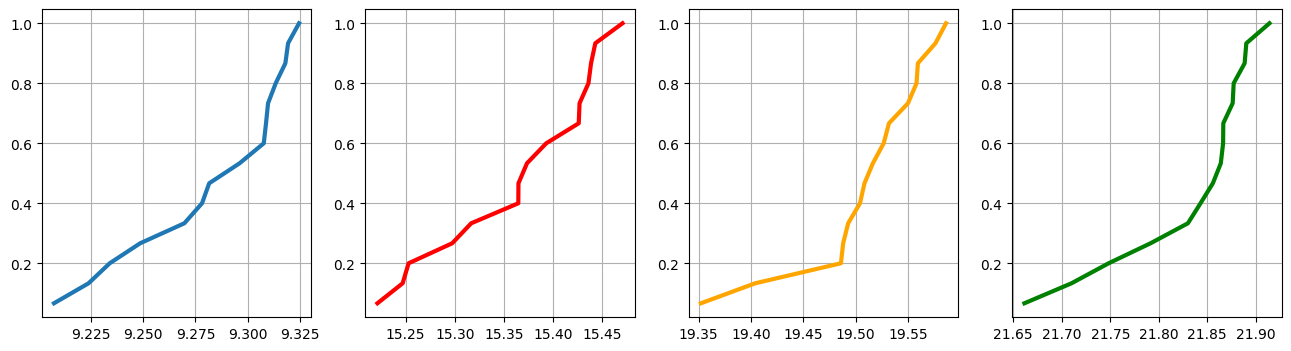

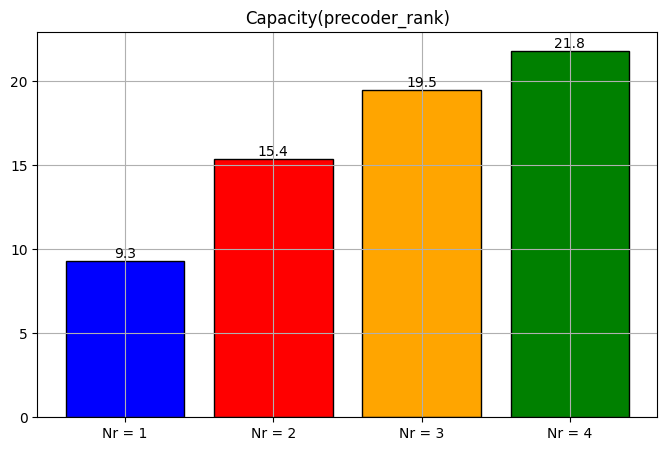

In [4]:
# Capacity of initial Channel
from extr_func import get_Capacity, cdf
import matplotlib.pyplot as plt


SNR = 30
channel_shape = list(H_dl.shape) + [1]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 строка, 4 столбца

Nr = 1  # precoder rank
Capacity1 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity1, Capacity_ideal_distr1 = cdf(Capacity1)
axs[0].plot(sort_capacity1, Capacity_ideal_distr1, lw=3)
axs[0].grid()

Nr = 2  # precoder rank
Capacity2 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity2, Capacity_ideal_distr2 = cdf(Capacity2)
axs[1].plot(sort_capacity2, Capacity_ideal_distr2, 'r', lw=3)
axs[1].grid()

Nr = 3  # precoder rank
Capacity3 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity3, Capacity_ideal_distr3 = cdf(Capacity3)
axs[2].plot(sort_capacity3, Capacity_ideal_distr3, 'orange', lw=3)
axs[2].grid()

Nr = 4  # precoder rank
Capacity4 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity4, Capacity_ideal_distr4 = cdf(Capacity4)
axs[3].plot(sort_capacity4, Capacity_ideal_distr4, 'g', lw=3)
axs[3].grid()


Capacity1_mean = float(np.mean(Capacity1))
Capacity2_mean = float(np.mean(Capacity2))
Capacity3_mean = float(np.mean(Capacity3))
Capacity4_mean = float(np.mean(Capacity4))

categories = ['Nr = 1', 'Nr = 2', 'Nr = 3', 'Nr = 4']
values = [Capacity1_mean, Capacity2_mean, Capacity3_mean, Capacity4_mean]

plt.figure(figsize=(8, 5))
named_colors = ['b', 'r', 'orange', 'g']
bars = plt.bar(categories, values, color=named_colors, edgecolor='black')
plt.grid()

# Добавляем значения над столбцами
plt.title('Capacity(precoder_rank)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',  # Форматирование до 1 знака после запятой
             ha='center', va='bottom')
    
len(Capacity4)

In [5]:
# tensorly CPD_ALS
from tensorly.decomposition import parafac
from tensorly.cp_tensor import cp_to_tensor

RankCP = 10
weights, factors = parafac(H_dl, rank=RankCP, n_iter_max=100, tol=1e-6, verbose=True)

reconstruction error=0.7124257121830387
iteration 1, reconstruction error: 0.20426855639844074, decrease = 0.508157155784598, unnormalized = 14.605046690068695
iteration 2, reconstruction error: 0.16452691756556595, decrease = 0.03974163883287479, unnormalized = 11.763549687652839
iteration 3, reconstruction error: 0.14746200009900604, decrease = 0.017064917466559915, unnormalized = 10.543421045459239
iteration 4, reconstruction error: 0.1375656290088597, decrease = 0.009896371090146322, unnormalized = 9.835838026407089
iteration 5, reconstruction error: 0.13125516815381358, decrease = 0.006310460855046135, unnormalized = 9.384644866535602
iteration 6, reconstruction error: 0.12578799813767438, decrease = 0.0054671700161391945, unnormalized = 8.993746361371123
iteration 7, reconstruction error: 0.12032672450575113, decrease = 0.0054612736319232524, unnormalized = 8.60326944320121
iteration 8, reconstruction error: 0.11524113727713799, decrease = 0.005085587228613145, unnormalized = 8.2

/Users/pavelkr/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pavelkr/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Nr = 1:  0.13 %
Nr = 2:  0.24 %
Nr = 3:  0.32 %
Nr = 4:  0.99 %


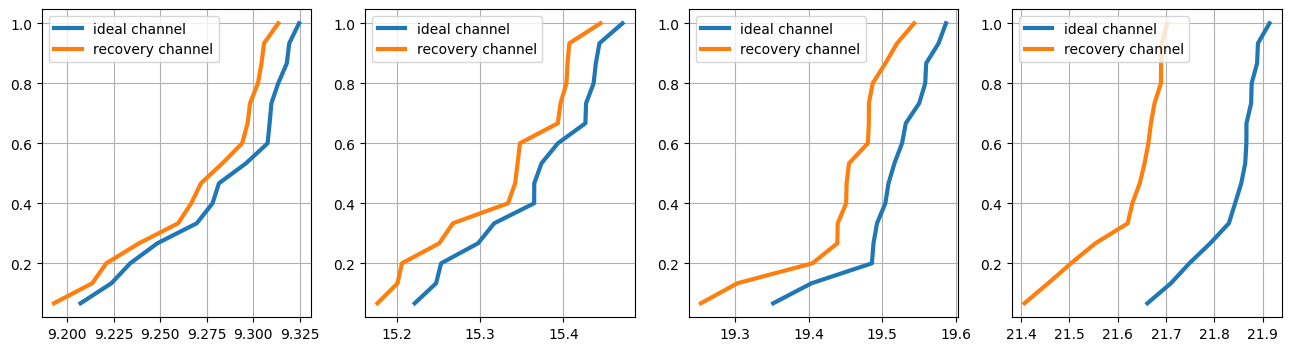

In [6]:

fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 строка, 4 столбца

H_dl_reconstr = cp_to_tensor((weights, factors))
ideal_capacity = [sort_capacity1, sort_capacity2, sort_capacity3, sort_capacity4]
ideal_cdf_capacity = [Capacity_ideal_distr1, Capacity_ideal_distr2, Capacity_ideal_distr3, Capacity_ideal_distr4]

errors = [0] * 4

for i in range(4):
    Nr = i + 1  # precoder rank
    Capacity_rec_1 = get_Capacity(H_dl, H_dl_reconstr, Nr, SNR, channel_shape)
    sort_capacity_rec, Capacity_rec_distr = cdf(Capacity_rec_1)
    axs[i].plot(ideal_capacity[i], ideal_cdf_capacity[i], lw=3)
    axs[i].plot(sort_capacity_rec, Capacity_rec_distr, lw=3)
    axs[i].grid()
    axs[i].legend(['ideal channel', 'recovery channel'])

    error = (np.mean(ideal_capacity[i]) - np.mean(sort_capacity_rec)) / np.mean(ideal_capacity[i]) * 100
    errors[i] = round(float(error), 2)
    # print(f'Error = {error} %')

for i in range(4):
    print(f'Nr = {i + 1}: ', errors[i], '%')


Iteration 0, relative error: 5.0675e-01
Iteration 1, relative error: 2.3729e-01
Iteration 2, relative error: 2.0053e-01
Iteration 3, relative error: 1.8521e-01
Iteration 4, relative error: 1.7507e-01
Iteration 5, relative error: 1.6723e-01
Iteration 6, relative error: 1.6080e-01
Iteration 7, relative error: 1.5542e-01
Iteration 8, relative error: 1.5090e-01
Iteration 9, relative error: 1.4714e-01
Iteration 10, relative error: 1.4405e-01
Iteration 11, relative error: 1.4151e-01
Iteration 12, relative error: 1.3939e-01
Iteration 13, relative error: 1.3759e-01
Iteration 14, relative error: 1.3600e-01
Iteration 15, relative error: 1.3456e-01
Iteration 16, relative error: 1.3320e-01
Iteration 17, relative error: 1.3189e-01
Iteration 18, relative error: 1.3059e-01
Iteration 19, relative error: 1.2929e-01
Iteration 20, relative error: 1.2800e-01
Iteration 21, relative error: 1.2673e-01
Iteration 22, relative error: 1.2552e-01
Iteration 23, relative error: 1.2442e-01
Iteration 24, relative err

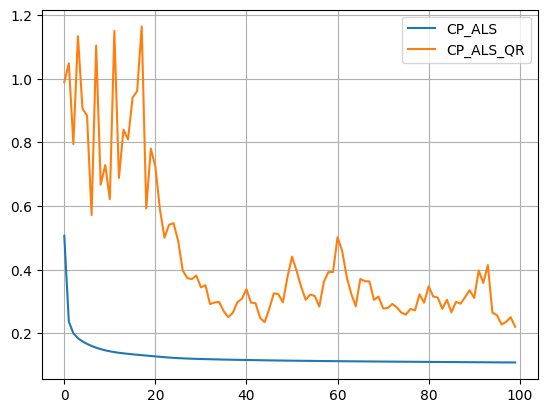

In [7]:
# my CPD_ALS and CPD_ALS_QR and CPD_Gradient compare (also test on images)
from CP_ALS import cp_als_complex, cp_als_qr_complex, reconstruct_tensor

data_cp_als = cp_als_complex(H_dl, RankCP, 100)
H_dl_reconstr = reconstruct_tensor(data_cp_als['lambdas'], data_cp_als['factors'])

data_cp_qr_als = cp_als_qr_complex(H_dl, RankCP, 100)
H_dl_qr_reconstr = reconstruct_tensor(data_cp_qr_als['lambdas'], data_cp_qr_als['factors'])

plt.plot(data_cp_als['errors'])
plt.plot(data_cp_qr_als['errors'])
plt.grid()
plt.legend(['CP_ALS', 'CP_ALS_QR'])

Nr = 1, CP_ALS Error:  0.16 %
Nr = 1, CP_ALS_QR Error:  1.32 %

Nr = 2, CP_ALS Error:  0.3 %
Nr = 2, CP_ALS_QR Error:  1.09 %

Nr = 3, CP_ALS Error:  0.16 %
Nr = 3, CP_ALS_QR Error:  1.96 %

Nr = 4, CP_ALS Error:  1.31 %
Nr = 4, CP_ALS_QR Error:  4.09 %



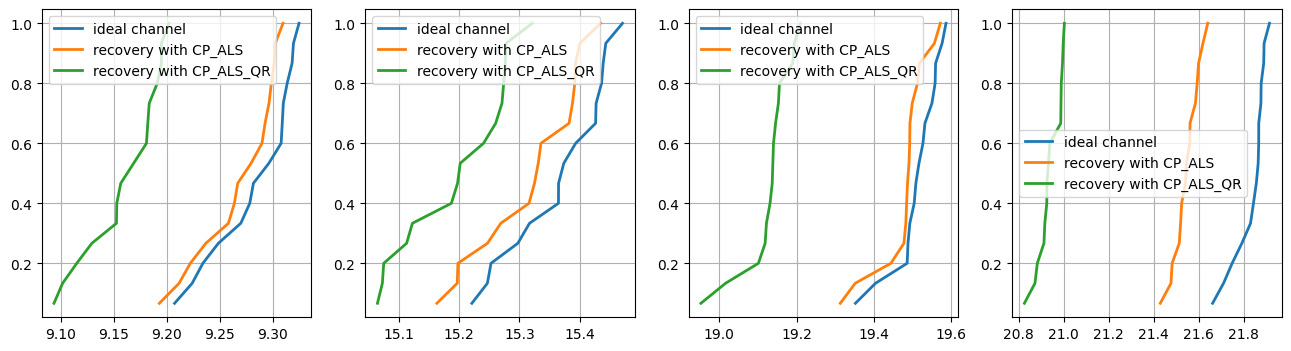

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 строка, 4 столбца

ideal_capacity = [sort_capacity1, sort_capacity2, sort_capacity3, sort_capacity4]
ideal_cdf_capacity = [Capacity_ideal_distr1, Capacity_ideal_distr2, Capacity_ideal_distr3, Capacity_ideal_distr4]

errors = [0] * 4

for i in range(4):
    Nr = i + 1  # precoder rank
    Capacity_rec_1 = get_Capacity(H_dl, H_dl_reconstr, Nr, SNR, channel_shape)
    sort_capacity_rec1, Capacity_rec_distr1 = cdf(Capacity_rec_1)

    Capacity_rec_2 = get_Capacity(H_dl, H_dl_qr_reconstr, Nr, SNR, channel_shape)
    sort_capacity_rec2, Capacity_rec_distr2 = cdf(Capacity_rec_2)

    axs[i].plot(ideal_capacity[i], ideal_cdf_capacity[i], lw=2)
    axs[i].plot(sort_capacity_rec1, Capacity_rec_distr1, lw=2)
    axs[i].plot(sort_capacity_rec2, Capacity_rec_distr2, lw=2)
    axs[i].grid()
    axs[i].legend(['ideal channel', 'recovery with CP_ALS', 'recovery with CP_ALS_QR'])

    error = (np.mean(ideal_capacity[i]) - np.mean(sort_capacity_rec1)) / np.mean(ideal_capacity[i]) * 100
    error_qr = (np.mean(ideal_capacity[i]) - np.mean(sort_capacity_rec2)) / np.mean(ideal_capacity[i]) * 100
    errors[i] = (round(float(error), 2), round(float(error_qr), 2))
    # print(f'Error = {error} %')

for i in range(4):
    print(f'Nr = {i + 1}, CP_ALS Error: ', errors[i][0], '%')
    print(f'Nr = {i + 1}, CP_ALS_QR Error: ', errors[i][1], '%')
    print()

In [9]:
print('Initial shape: ', H_dl.shape)
print()
print('Shape after compression: ')
print(data_cp_als['factors'][0].shape)
print(data_cp_als['factors'][1].shape)
print(data_cp_als['factors'][2].shape)
print(data_cp_als['factors'][3].shape)

Initial shape:  (12, 4, 50, 15)

Shape after compression: 
(12, 10)
(4, 10)
(50, 10)
(15, 10)


In [10]:
V1 = 12 * 4 * 50 * 15
V2 = (12 + 4 + 50 + 15) * RankCP

print(V1, V2)
print('Сжатие в ', round(V1 / V2, 2), 'раз')

36000 810
Сжатие в  44.44 раз


In [11]:
# My method compression: Tensorization + CPD_ALS on MIMO channel
from Tensorization import reshape_with_prime_factors

print(H_dl.shape)
H_dl_reshape = reshape_with_prime_factors(H_dl)
print(H_dl_reshape.shape)
data_cp_als_tenz = cp_als_complex(H_dl_reshape, RankCP, 100)

Разложенная форма: (2, 2, 5, 5, 2, 3)
Восстановленная форма: (4, 25, 6)
Данные совпадают: True
(12, 4, 50, 15)
(2, 2, 3, 2, 2, 2, 5, 5, 3, 5)
Iteration 0, relative error: 7.0985e-01
Iteration 1, relative error: 4.0947e-01
Iteration 2, relative error: 3.5488e-01
Iteration 3, relative error: 3.2665e-01
Iteration 4, relative error: 3.0407e-01
Iteration 5, relative error: 2.8756e-01
Iteration 6, relative error: 2.7455e-01
Iteration 7, relative error: 2.6579e-01
Iteration 8, relative error: 2.6269e-01
Iteration 9, relative error: 2.6153e-01
Iteration 10, relative error: 2.6081e-01
Iteration 11, relative error: 2.6023e-01
Iteration 12, relative error: 2.5971e-01
Iteration 13, relative error: 2.5920e-01
Iteration 14, relative error: 2.5868e-01
Iteration 15, relative error: 2.5814e-01
Iteration 16, relative error: 2.5756e-01
Iteration 17, relative error: 2.5694e-01
Iteration 18, relative error: 2.5630e-01
Iteration 19, relative error: 2.5563e-01
Iteration 20, relative error: 2.5488e-01
Iterati

In [12]:
data_cp_als_tenz

{'lambdas': array([10.15258588, 14.07628299, 18.24677409, 12.21866396, 47.30777125,
        18.33346093, 16.64697214,  7.18212151, 35.78347488, 10.68692035]),
 'factors': [array([[-0.06368743+0.76700794j, -0.0351876 -0.10473422j,
          -0.49698054-0.10591298j,  0.26494348+0.72385211j,
           0.59593755-0.22598136j,  0.83410139+0.112261j  ,
          -0.31416124-0.19921019j,  0.61850642+0.61975983j,
           0.09786343+0.81985976j, -0.73039043-0.34077304j],
         [-0.43137656+0.47069842j, -0.97558856-0.18978815j,
           0.36971267+0.77788516j, -0.05137288-0.63498338j,
          -0.45687723-0.62052724j, -0.07941881-0.53419564j,
           0.82838317+0.41880703j,  0.01677434-0.48276929j,
          -0.16436576-0.53966344j, -0.23994368-0.54113823j]]),
  array([[-2.00522969e-01-0.64523933j, -3.72775867e-01+0.87653583j,
           8.50579788e-01+0.32035689j, -6.49351138e-01+0.10804165j,
           7.82906485e-02+0.7343216j ,  4.51747700e-02+0.74679534j,
           4.68899347e

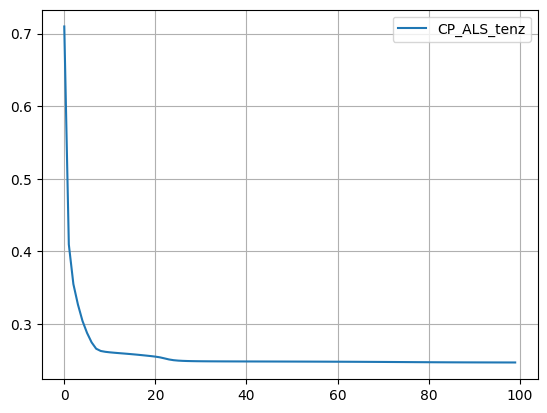

In [13]:
plt.plot(data_cp_als_tenz['errors'])
plt.grid()
plt.legend(['CP_ALS_tenz'])

In [14]:
data_cp_als_tenz['factors'][2].shape

(3, 10)

In [15]:
H_dl_tenz_reconstr = reconstruct_tensor(data_cp_als_tenz['lambdas'], data_cp_als_tenz['factors'])

In [16]:
H_dl_tenz_reconstr.shape

(2, 2, 3, 2, 2, 2, 5, 5, 3, 5)

In [17]:
from Tensorization import inverse_reshape_with_prime_factors

restored_tensor = inverse_reshape_with_prime_factors(H_dl_tenz_reconstr, H_dl.shape)

In [21]:
print(restored_tensor.shape)
rel_error = np.linalg.norm(H_dl - restored_tensor) / np.linalg.norm(H_dl)
rel_error

(12, 4, 50, 15)


0.2468194572234016